# Initialize the accelerator

In [1]:
# apt-get install libhdf5-dev
#! pip install --upgrade pip setuptools wheel
! pip install versioned-hdf5
#! pip install h5py

     |████████████████████████████████| 1.5 MB 2.1 MB/s eta 0:00:01     |██████████████▋                 | 706 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 821 kB 6.9 MB/s eta 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 56.2.0
    Uninstalling setuptools-56.2.0:
      Successfully uninstalled setuptools-56.2.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.1
    Uninstalling pip-21.1.1:
      Successfully uninstalled pip-21.1.1


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/xilinx/radioml_deploy'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from driver.driver_base import FINNExampleOverlay
from finn.core.datatype import DataType

In [3]:
# taken from generated driver.py:
io_shape_dict = {
    # FINN DataType for input and output tensors
    "idt" : DataType.INT8,
    "odt" : DataType.UINT8,
    # shapes for input and output tensors (NHWC layout)
    "ishape_normal" : (1, 128, 1, 16),
    "oshape_normal" : (1, 1),
    # folded / packed shapes below depend on idt/odt and input/output
    # PE/SIMD parallelization settings -- these are calculated by the
    # FINN compiler.
    "ishape_folded" : (1, 128, 1, 4, 4),
    "oshape_folded" : (1, 1, 1),
    "ishape_packed" : (1, 128, 1, 4, 4),
    "oshape_packed" : (1, 1, 1),
    "input_dma_name" : 'idma0',
    "number_of_external_weights": 0
}

accel = FINNExampleOverlay(
        bitfile_name = "/home/xilinx/radioml_deploy/bitfile/finn-accel.bit", platform = "zynq-iodma",
        io_shape_dict = io_shape_dict, batch_size = 1, fclk_mhz = 187.0)

In [4]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 128, 1, 16) DataType.INT8
Expected output shape and datatype: (1, 1) DataType.UINT8


# Load RadioML 2018 dataset

In [5]:
import numpy as np
import pickle
import os
import h5py

val_dir = "/home/xilinx/dataset/RadioML"
print(val_dir)

/home/xilinx/dataset/RadioML


In [6]:
h5_file = h5py.File(val_dir + "/2018/GOLD_XYZ_OSC.0001_1024.hdf5",'r')
X = h5_file['X']
Y = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
Z = h5_file['Z'][:,0]

np.random.seed(2018)
test_indices = []
for mod in range(0, 24): #all modulations (0 to 23)
    for snr_idx in range(0, 26): #all SNRs (0 to 25 = -20dB to +30dB)
        start_idx = 26*4096*mod + 4096*snr_idx
        indices_subclass = list(range(start_idx, start_idx+4096))

        split = int(np.ceil(0.1 * 4096)) #90%/10% split
        np.random.shuffle(indices_subclass)
        train_indices_subclass, val_indices_subclass = indices_subclass[split:], indices_subclass[:split]

        if snr_idx >= 25: #only SNR >= +30dB
            test_indices.extend(val_indices_subclass)

test_indices = np.sort(test_indices)

X_test = X[test_indices]
Y_test = Y[test_indices]
Z_test = Z[test_indices]

# bring into 4D NHWC format
#X_test = np.expand_dims(X_test, 2)

# note: labels given in the "classes.txt" file are not in the correct order (https://github.com/radioML/dataset/issues/25)
self.mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
'16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

In [7]:
print(X_test.shape)
print(Y_test.shape)
print(Z_test.shape)
print(test_indices)

(9840, 1024, 2)
(9840,)
(9840,)
[ 102401  102404  102414 ... 2555870 2555878 2555889]


# Inspect a single sample

In [8]:
from matplotlib import pyplot as plt

idx = 1086
data, mod, snr = X_test[idx], Y_test[idx], Z_test[idx]
plt.figure()
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB" % (mod_classes[mod], snr))

Modulation: 32QAM, SNR: 30.0 dB


# Quantize dataset

Modulation: 32QAM, SNR: 30.0 dB


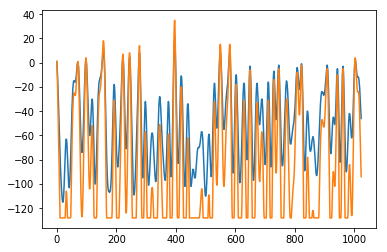

In [9]:
def quantize(data, quant_min, quant_max):
    quant_range = quant_max - quant_min
    data_quant = (data - quant_min) / quant_range
    data_quant = np.round(data_quant * 256) - 128
    data_quant = np.clip(data_quant, -128, 127)
    data_quant = data_quant.astype(np.int8)
    return data_quant

#whole validation set:
quant_min = -2.0
quant_max = 2.0
X_test = quantize(X_test, quant_min, quant_max)

idx = 1086
data, mod, snr = X_test[idx], Y_test[idx], Z_test[idx]
plt.figure()
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB" % (mod_classes[mod], snr))

# Classify a single sample

In [10]:
accel_in = data.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 128, 1, 16) and datatype is int8


In [11]:
accel_out = accel.execute(accel_in)
#accel_out = post_process(accel_out)

In [13]:
print("Result: " + str(accel_out))
print("Top-1 class predicted by the accelerator: " + mod_classes[int(accel_out)])

Result: [[18.]]
Top-1 class predicted by the accelerator: 64QAM


In [14]:
%%timeit
accel_out = accel.execute(accel_in)

1000 loops, best of 3: 843 µs per loop


# Validate accuracy on entire validation set

In [15]:
batch_size = 120
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_folded), str(accel.oshape_folded)) )
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_normal), str(accel.oshape_normal)) )

Accelerator buffer shapes are (120, 128, 1, 4, 4) for input, (120, 1, 1) for output
Accelerator buffer shapes are (120, 128, 1, 4, 4) for input, (120, 1, 1) for output
Accelerator buffer shapes are (120, 128, 1, 16) for input, (120, 1) for output


In [32]:
ok = 0
nok = 0
for i in range(int(X_test.shape[0]/batch_size)):
    batch_idx = i*batch_size
    data, mod, snr = X_test[batch_idx:batch_idx+batch_size], Y_test[batch_idx:batch_idx+batch_size], Z_test[batch_idx:batch_idx+batch_size]

    data = data.transpose(0,2,1)
    data = data.reshape(-1, 16, 128)
    data = data.transpose(0,2,1)
    #x = x.reshape(-1,2,int(1024/interleave),int(interleave))
    #x = x.permute(0,1,3,2).contiguous()
    ibuf_normal = data.reshape(accel.ishape_normal)
    obuf_normal = accel.execute(ibuf_normal)
    obuf_normal = obuf_normal.reshape(batch_size)
    #obuf_normal = post_process(obuf_normal)
    
    pred = obuf_normal.astype(int)
    
    print(data.shape)
    print(ibuf_normal.shape)
    #print(obuf_normal.shape)  
    #print(mod.shape)
    #print(pred.shape)
    
    ok += np.equal(pred, mod).sum().item()
    nok += np.not_equal(pred, mod).sum().item()
    
    print("batch %d : total OK %d NOK %d" % (i, ok, nok))

(120, 128, 16)
(120, 128, 1, 16)
batch 0 : total OK 119 NOK 1
(120, 128, 16)
(120, 128, 1, 16)
batch 1 : total OK 239 NOK 1
(120, 128, 16)
(120, 128, 1, 16)
batch 2 : total OK 359 NOK 1
(120, 128, 16)
(120, 128, 1, 16)
batch 3 : total OK 471 NOK 9
(120, 128, 16)
(120, 128, 1, 16)
batch 4 : total OK 585 NOK 15
(120, 128, 16)
(120, 128, 1, 16)
batch 5 : total OK 691 NOK 29
(120, 128, 16)
(120, 128, 1, 16)
batch 6 : total OK 792 NOK 48
(120, 128, 16)
(120, 128, 1, 16)
batch 7 : total OK 894 NOK 66
(120, 128, 16)
(120, 128, 1, 16)
batch 8 : total OK 998 NOK 82
(120, 128, 16)
(120, 128, 1, 16)
batch 9 : total OK 1105 NOK 95
(120, 128, 16)
(120, 128, 1, 16)
batch 10 : total OK 1219 NOK 101
(120, 128, 16)
(120, 128, 1, 16)
batch 11 : total OK 1339 NOK 101
(120, 128, 16)
(120, 128, 1, 16)
batch 12 : total OK 1459 NOK 101
(120, 128, 16)
(120, 128, 1, 16)
batch 13 : total OK 1579 NOK 101
(120, 128, 16)
(120, 128, 1, 16)
batch 14 : total OK 1698 NOK 102
(120, 128, 16)
(120, 128, 1, 16)
batch 15 :

In [33]:
total = X_test.shape[0]
acc = 100.0 * ok / (total)
print("30dB top-1 accuracy: {}%".format(acc))

30dB top-1 accuracy: 72.39837398373983%


## More benchmarking

In [50]:
accel.batch_size = 1000
accel.throughput_test()

{'DRAM_in_bandwidth[Mb/s]': 435.46256676467607,
 'DRAM_out_bandwidth[Mb/s]': 0.2126282064280645,
 'batch_size': 1000,
 'copy_input_data_to_device[ms]': 1.878499984741211,
 'copy_output_data_from_device[ms]': 0.08535385131835938,
 'fclk[mhz]': 187.498125,
 'fold_input[ms]': 0.09822845458984375,
 'pack_input[ms]': 0.11038780212402344,
 'runtime[ms]': 4.703044891357422,
 'throughput[images/s]': 212628.20642806447,
 'unfold_output[ms]': 0.08726119995117188,
 'unpack_output[ms]': 0.6067752838134766}